# Lab 01 : Vanilla Faster R-CNN - solution

The goal is to implement the forward pass of the vanilla faster CNN architecture at test time.

In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS4243_codes/codes/labs_lecture11'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import utils
import time

In [3]:
#device= torch.device("cuda")
device= torch.device("cpu")
print(device)

cpu


### Generate the dataset 

In [4]:
# Libraries
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings

# Import 5 object types
nb_class_objects = 5
objects = torch.zeros(nb_class_objects,7,7)
for k in range(nb_class_objects):
    objects[k,:,:] = 1-ToTensor()(Image.open('objects/obj'+str(k+1)+'.tif'))[0,:,:]
print(objects.size())

# Define the bounding boxes w.r.t. object type
def box_coord(label, x, y, w):
    offset = (w-1)// 2 + 0.5
    x = [x-offset, x-offset+w, x-offset+w, x-offset,   x-offset]
    y = [y-offset, y-offset,   y-offset+w, y-offset+w, y-offset]
    if label==0:
        color = 'r'; legend = 'Triangle'
    elif label==1:
        color = 'b'; legend = 'Cross'
    elif label==2:
        color = 'g'; legend = 'Star'
    elif label==3:
        color = 'y'; legend = 'Square'
    elif label==4:
        color = 'm'; legend = 'Ring'
    return x, y, color, legend

torch.Size([5, 7, 7])


torch.Size([2, 28, 28])
torch.Size([2, 3, 5])


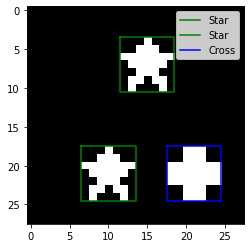

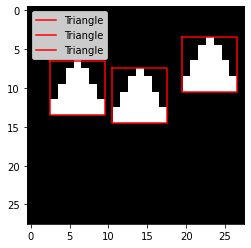

In [5]:
# Global constants
# im_size = image size  
# ob_size = object size
# batch_size = batch size
# nb_objects = number of objects in the image
# nb_class_objects = number of object classes (we have 5 classes)
# hidden_dim = hidden dimension

im_size = 28 
ob_size = 7
offset = (ob_size-1)// 2 
batch_size = 2 
nb_objects = 3
hidden_dim = 64

# Function that generate a batch of training data
def generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_class_objects):
    batch_images = torch.zeros(batch_size,im_size,im_size)
    batch_bboxes = torch.zeros(batch_size,nb_objects,4+1) # 2D-coord, width and height of boxes, and their class
    for b in range(batch_size):
        image = torch.zeros(im_size,im_size)
        bboxes = torch.zeros(nb_objects,4+1)
        class_objects = torch.LongTensor(nb_objects).random_(0,nb_class_objects)
        offset = (ob_size-1)// 2
        coord_objects = torch.LongTensor(nb_objects,2).random_(offset,im_size-offset)
        # coord_objects[k,0] = x-coordinate,  coord_objects[k,1] = y-coordinate
        for k in range(nb_objects):
            image[coord_objects[k,1]-offset:coord_objects[k,1]-offset+ob_size,coord_objects[k,0]-offset:coord_objects[k,0]-offset+ob_size] += objects[class_objects[k],:,:]; image[image>=1.0] = 1.0
            bboxes[k,:] = torch.Tensor([coord_objects[k,0],coord_objects[k,1],ob_size,ob_size,class_objects[k]])
        batch_images[b,:,:] = image
        batch_bboxes[b,:,:] = bboxes
    return batch_images, batch_bboxes

# Plot a mini-batch of images
batch_images, batch_bboxes = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_class_objects)
print(batch_images.size())
print(batch_bboxes.size())
for b in range(batch_size):
    plt.imshow(batch_images[b,:,:], cmap='gray')
    for k in range(nb_objects):
        x, y, color, legend = box_coord(batch_bboxes[b,k,4],batch_bboxes[b,k,0],batch_bboxes[b,k,1],ob_size)
        plt.plot(x,y,color,label=legend)
    plt.legend(loc='best')
    plt.show() 



In [6]:
# Define the faster-R-CNN architecture
batch_size = 2 # for debug

class faster_R_CNN(nn.Module):
    
    def __init__(self):
        super(faster_R_CNN, self).__init__()
        # backbone convnet
        self.conv1 = nn.Conv2d(1,  hidden_dim,  kernel_size=3, padding=1 ) #  1x28x28 --> hidden_dimx 28x28 
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1 ) # hidden_dim x28x28 --> hidden_dim x28x28 
        # Bbox classes
        self.linear_class = nn.Linear(hidden_dim* ob_size**2, nb_class_objects) # hidden_dim x7x7 --> nb_class_objects 
        # Bbox anchors
        self.conv_anch = nn.Conv2d(hidden_dim, 1, kernel_size=ob_size, padding=offset )  # hidden_dim x28x28 --> 1x28x28 
        
    def forward(self, x, bb, train_flag=True):
        # backbone convnet
        x = self.conv1(x) # [batch_size, hidden_dim, im_size, im_size] 
        x = torch.relu(x)
        x = self.conv2(x) # [batch_size,hidden_dim, im_size, im_size]
        x = torch.relu(x) 
        # Bbox anchors
        scores_bbox_anch = self.conv_anch(x).squeeze() # [batch_size, im_size, im_size] 
        # Bbox classes
        if train_flag: # forward pass at training time
            bbox = []
            for b in range(batch_size):
                for k in range(nb_objects):
                    bbox.append(x[b,:,bb[b,k,1].long()-offset:bb[b,k,1].long()-offset+ob_size,bb[b,k,0].long()-offset:bb[b,k,0].long()-offset+ob_size])
            bbox = torch.stack(bbox, dim=0) # [batch_size*nb_objects, hidden_dim, ob_size, ob_size]
            bbox = bbox.view(-1, hidden_dim * ob_size**2) # [batch_size*nb_objects, hidden_dim*ob_size*ob_size]
            scores_bbox_class = self.linear_class(bbox) # [batch_size*nb_objects, nb_class_objects]
        else: # forward pass at test time
            batch_bbox = []
            for b in range(batch_size):
                # compute the coordinates of the top-K bbox anchor scores (K=nb_objects)
                # COMPLETE HERE
                scores_bbox_anch_b = scores_bbox_anch[b,:,:] # [im_size, im_size]
                scores_bbox_anch_b = scores_bbox_anch_b.view(-1) # [im_size*im_size]
                _, idx_largest = torch.sort(scores_bbox_anch_b, descending=True) # [im_size*im_size]
                idx_largest = idx_largest[:nb_objects] # [nb_objects]
                idx_y = idx_largest//im_size # [nb_objects]
                idx_x = idx_largest - idx_y*im_size # [nb_objects]
                # extract the top-K bboxes of size [batch_size, nb_objects, hidden_dim, ob_size, ob_size]
                # COMPLETE HERE
                bbox = []
                for k in range(nb_objects):
                    bbox.append(x[b,:,idx_y[k]-offset:idx_y[k]-offset+ob_size,idx_x[k]-offset:idx_x[k]-offset+ob_size])
                bbox = torch.stack(bbox, dim=0) # [nb_objects, hidden_dim, ob_size, ob_size]
                bbox = bbox.view(-1, hidden_dim * ob_size**2) # [nb_objects, hidden_dim*ob_size*ob_size]
                batch_bbox.append(bbox)
            # compute the class scores of the bbox
            # size of tensor scores_bbox_class is [batch_size*nb_objects, nb_class_objects]
            # COMPLETE HERE
            batch_bbox = torch.cat(batch_bbox, dim=0) # [batch_size*nb_objects, hidden_dim*ob_size*ob_size]
            scores_bbox_class = self.linear_class(batch_bbox) # [batch_size*nb_objects, nb_class_objects]
        return scores_bbox_class, scores_bbox_anch
    
# Instantiate the network
net = faster_R_CNN()
net = net.to(device)
print(net)
utils.display_num_param(net) 

# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
batch_images, batch_bboxes = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_class_objects)
optimizer.zero_grad()
scores_bbox_class, scores_bbox_anch = net(batch_images.unsqueeze(dim=1), batch_bboxes)
# Bbox class loss
labels_bbox_class = batch_bboxes[:,:,4].long().view(-1) # [batch_size*nb_objects]
loss_class = nn.CrossEntropyLoss()(scores_bbox_class, labels_bbox_class)
# Bbox anchors loss
labels_bbox_coord = batch_bboxes[:,:,0:2] # [batch_size, nb_objects, 2D]
labels_bbox_anch = torch.zeros(batch_size, im_size, im_size) # [batch_size, im_size, im_size]
for b in range(batch_size):
    for k in range(nb_objects): 
        labels_bbox_anch[b,labels_bbox_coord[b,k,1].long(),labels_bbox_coord[b,k,0].long()] = 1
loss_anch = torch.nn.BCEWithLogitsLoss()(scores_bbox_anch, labels_bbox_anch)
loss = loss_class + loss_anch
loss.backward()
optimizer.step()


faster_R_CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear_class): Linear(in_features=3136, out_features=5, bias=True)
  (conv_anch): Conv2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
)
There are 56390 (0.06 million) parameters in this neural network


In [7]:
# Training loop
net = faster_R_CNN()
net = net.to(device)
utils.display_num_param(net) 

# Optimizer
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)

# Number of mini-batches per epoch
nb_batch = 10
batch_size = 10

start=time.time()
for epoch in range(10):

    running_loss = 0.0
    num_batches = 0
    
    for _ in range(nb_batch):
        
        # FORWARD AND BACKWARD PASS
        batch_images, batch_bboxes = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_class_objects)
        optimizer.zero_grad()
        scores_bbox_class, scores_bbox_anch = net(batch_images.unsqueeze(dim=1), batch_bboxes)
        # Bbox class loss
        labels_bbox_class = batch_bboxes[:,:,4].long().view(-1) # [batch_size*nb_objects]
        loss_class = nn.CrossEntropyLoss()(scores_bbox_class, labels_bbox_class)
        # Bbox anchors loss
        labels_bbox_coord = batch_bboxes[:,:,0:2] # [batch_size, nb_objects, 2D]
        labels_bbox_anch = torch.zeros(batch_size, im_size, im_size) # [batch_size, im_size, im_size]
        for b in range(batch_size):
            for k in range(nb_objects): 
                labels_bbox_anch[b,labels_bbox_coord[b,k,1].long(),labels_bbox_coord[b,k,0].long()] = 1
        loss_anch = torch.nn.BCEWithLogitsLoss()(scores_bbox_anch, labels_bbox_anch)
        loss = loss_class + loss_anch
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1        
    
    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', init_lr  ,'\t loss=', total_loss )
    

There are 56390 (0.06 million) parameters in this neural network
epoch= 0 	 time= 0.009257165590922038 min 	 lr= 0.001 	 loss= 1.604188871383667
epoch= 1 	 time= 0.017982828617095947 min 	 lr= 0.001 	 loss= 0.46088439524173735
epoch= 2 	 time= 0.02692493200302124 min 	 lr= 0.001 	 loss= 0.14255752712488173
epoch= 3 	 time= 0.03566849629084269 min 	 lr= 0.001 	 loss= 0.07790145725011825
epoch= 4 	 time= 0.04410181442896525 min 	 lr= 0.001 	 loss= 0.03952244129031897
epoch= 5 	 time= 0.052849066257476804 min 	 lr= 0.001 	 loss= 0.032296616770327094
epoch= 6 	 time= 0.06130341291427612 min 	 lr= 0.001 	 loss= 0.02316691856831312
epoch= 7 	 time= 0.07016264994939168 min 	 lr= 0.001 	 loss= 0.02355303643271327
epoch= 8 	 time= 0.07908019622166952 min 	 lr= 0.001 	 loss= 0.017341663129627705
epoch= 9 	 time= 0.08788613080978394 min 	 lr= 0.001 	 loss= 0.01122361170127988


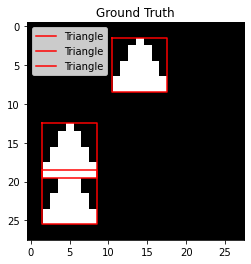

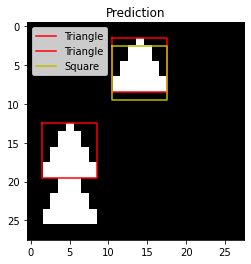

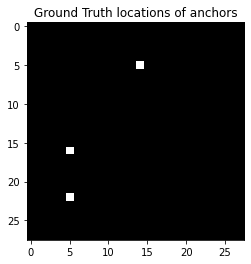

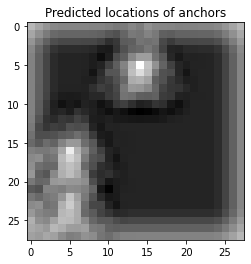

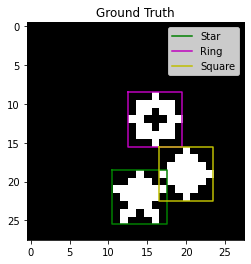

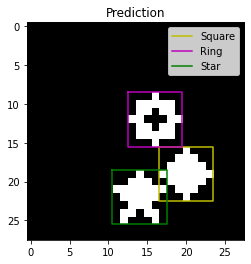

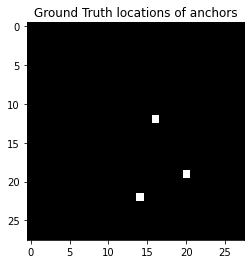

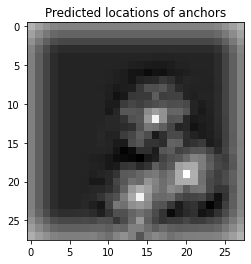

In [10]:
# Test time

# select a batch of 2 images
batch_size = 2 

# generate the batch of 2 images
batch_images, batch_bboxes = generate_batch_data(im_size, ob_size, batch_size, nb_objects, nb_class_objects)

# Forward pass during TEST time
#  Note the flag "train_flag=False"
scores_bbox_class, scores_bbox_anch = net(batch_images.unsqueeze(dim=1), batch_bboxes, train_flag=False)
         
# scores_bbox_class [batch_size*nb_objects, nb_class_objects] 
bbox_class = torch.argmax(scores_bbox_class, dim=-1) # [batch_size*nb_objects] 
bbox_class = bbox_class.view(batch_size, nb_objects) # [batch_size, nb_objects] 

# Ground tructh Bbox anchors
labels_bbox_coord = batch_bboxes[:,:,0:2] # [batch_size, nb_objects, 2]
labels_bbox_anch = torch.zeros(batch_size, im_size, im_size) # [batch_size, im_size, im_size]
for b in range(batch_size):
    for k in range(nb_objects): 
        labels_bbox_anch[b,labels_bbox_coord[b,k,1].long(),labels_bbox_coord[b,k,0].long()] = 1
    
# Plot the ground truth solution and the predicted solution
for b in range(batch_size):
    
    # Plot ground truth and prediction
    plt.imshow(batch_images[b,:,:], cmap='gray')
    for k in range(nb_objects):
        x, y, color, legend = box_coord(batch_bboxes[b,k,4],batch_bboxes[b,k,0],batch_bboxes[b,k,1],ob_size)
        plt.plot(x,y,color,label=legend)
    plt.legend(loc='best')
    plt.title('Ground Truth')
    plt.show() 
    # Predicted anchor coordinates
    scores_bbox_anch_b = scores_bbox_anch[b,:,:].detach()
    scores_bbox_anch_b = scores_bbox_anch_b.view(-1)
    _, idx_largest = torch.sort(scores_bbox_anch_b, descending=True) # rank the scores from largest to smallest
    idx_largest = idx_largest[:nb_objects] # get the top scores
    idx_y = idx_largest//im_size        # compute y-coord of anchor locations
    idx_x = idx_largest - idx_y*im_size # compute x-coord of anchor locations
    # Predicted classes for the boxes
    bbox_class = torch.argmax(scores_bbox_class, dim=-1) # [batch_size*nb_objects]
    bbox_class = bbox_class.view(batch_size, nb_objects) # [batch_size, nb_objects]
    plt.imshow(batch_images[b,:,:], cmap='gray')
    for k in range(nb_objects):
        x, y, color, legend = box_coord(bbox_class[b,k],idx_x[k],idx_y[k],ob_size) # Predicted classes
        plt.plot(x,y,color,label=legend)
    plt.legend(loc='best')
    plt.title('Prediction')
    plt.show() 
    
    # Plot ground truth and predicted locations of anchors
    plt.imshow(labels_bbox_anch[b,:,:], cmap='gray')
    plt.title('Ground Truth locations of anchors')
    plt.show() 
    plt.imshow(scores_bbox_anch[b,:,:].detach(), cmap='gray')
    plt.title('Predicted locations of anchors')
    plt.show() 
